In [1]:
import torch
from torch import nn 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm 

Basic idea of GAN is a competition between generator and discriminator 

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [4]:
dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.70MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
def output(dataset, limit):
    for i, (x, _) in enumerate(dataset):
        t_x = x.permute(1, 2, 0)
    
        plt.figure(figsize=(10, 6))
    
        plt.subplot(1, 2, 1)
        plt.imshow(t_x, cmap="gray")
        plt.title("Input")
    
        plt.subplot(1, 2, 2)
        plt.imshow(t_x, cmap="gray")
        plt.title("Output")
    
        if i+1 >= limit:
            break
    

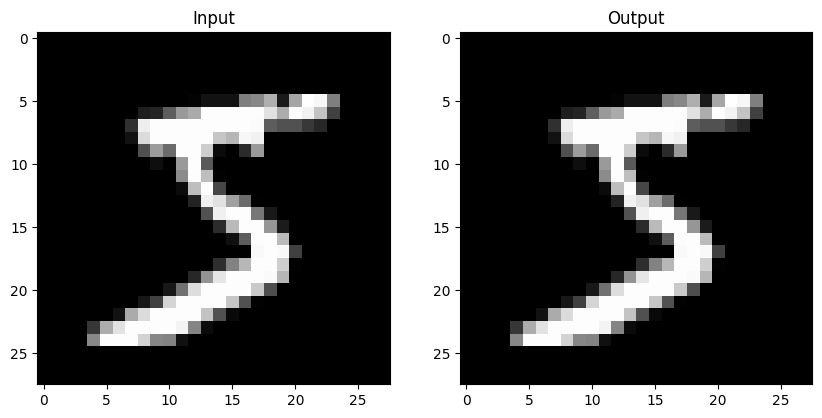

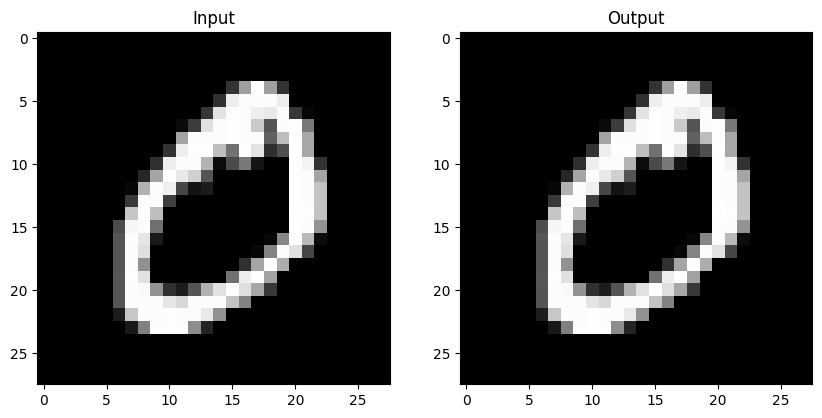

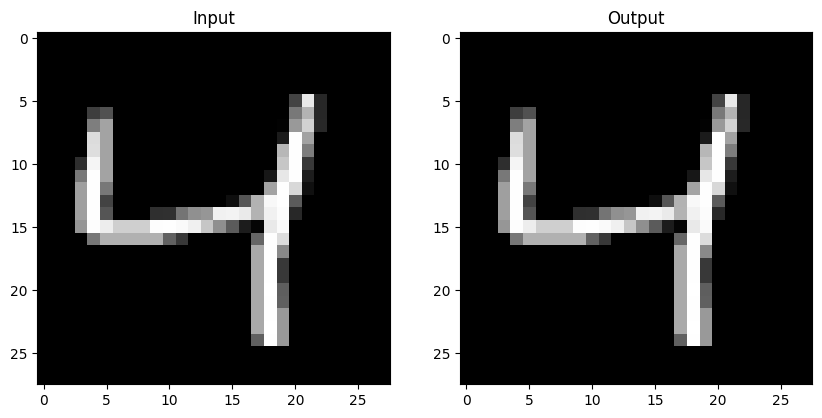

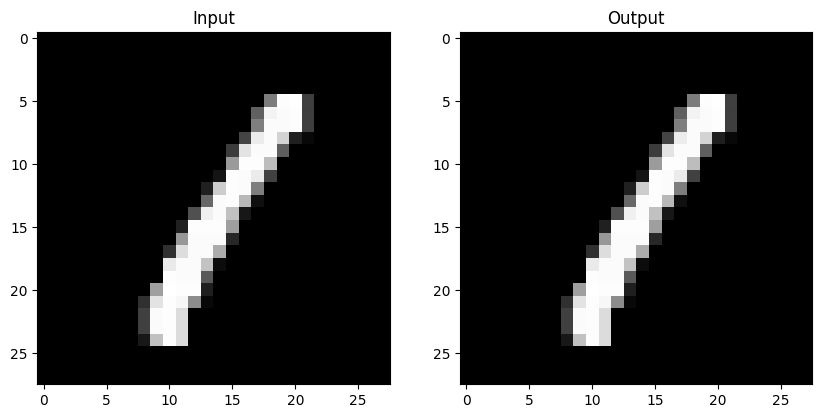

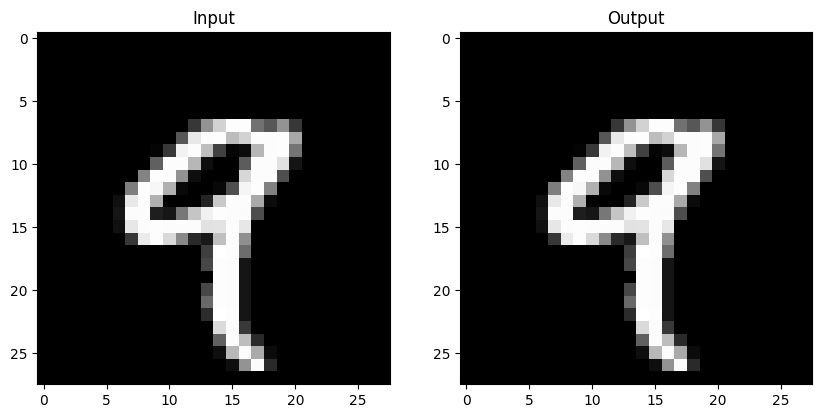

In [8]:
 output(dataset, 5)

In [9]:
x, y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [29]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.linear1 = nn.Linear(latent_dim, 256)
        self.bnorm1 = nn.BatchNorm1d(256)
        self.linear2 = nn.Linear(256, 512)
        self.bnorm2 = nn.BatchNorm1d(512)
        self.linear3 = nn.Linear(512, 1024)
        self.bnorm3 = nn.BatchNorm1d(1024)
        self.linear4 = nn.Linear(1024, 28*28)

    def forward(self, x):
        out = F.leaky_relu(self.bnorm1(self.linear1(x)))
        out = F.leaky_relu(self.bnorm2(self.linear2(out)))
        out = F.leaky_relu(self.bnorm3(self.linear3(out)))
        out = F.tanh(self.linear4(out))
        res = out.view(out.size(0), * (1, 28, 28))
        return res


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(1*28*28, 1024)
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 1)

        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.dropout(F.leaky_relu(self.linear1(x)))
        out = self.dropout(F.leaky_relu(self.linear2(out)))
        res = F.sigmoid(self.linear3(out))
        return res
        
        

In [31]:
discriminator = Discriminator()
generator = Generator()

In [33]:
optimizer_D = Adam(discriminator.parameters(), lr=1e-5, betas=(0.3, 0.999))
optimizer_G = Adam(generator.parameters(), lr=1e-3, betas=(0.3, 0.999))

In [34]:
adv_loss = nn.BCELoss()

In [35]:
# discriminator loss: -0.5 * [log D(x) + log(1-D(G(z)))]
# generator loss: -log(D(G(z)))

# to generate realistic image, generator should work better, that discriminator

def train(epochs, dl, optimizer_D, optimizer_G, adv_loss):
    history = {
        "generator_loss": [],
        "discriminator_loss": []
    }

    for epoch in range(epochs):
        generator_loss = 0
        discriminator_loss = 0
        for x, _ in tqdm(dl):
            reals = torch.ones(x.size(0), 1)
            fakes = torch.zeros(x.size(0), 1)

            optimizer_D.zero_grad()

            # log D(x)
            real_loss = adv_loss(discriminator(x), reals)

            z = torch.rand(x.size(0), 128)
            gen_imgs = generator(z)
            # gen_imgs = D(G(z))

            # log(1-D(G(z)))
            fake_loss = adv_loss(discriminator(gen_imgs.detach()), fakes)

            # -0.5 * [log D(x) + log(1-D(G(z)))]
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            
            discriminator_loss += d_loss.item()

            optimizer_G.zero_grad()
            
            
            # -log(D(G(z)))
            g_loss = adv_loss(discriminator(gen_imgs), reals)
            g_loss.backward()
            optimizer_G.step()

            generator_loss += g_loss.item()

        fin_generator_loss = generator_loss / len(dl)
        fin_discriminator_loss = discriminator_loss / len(dl)

        history["generator_loss"].append(fin_generator_loss)
        history["discriminator_loss"].append(fin_discriminator_loss)

        print(f"Epoch: {epoch+1}, Generator_loss: {fin_generator_loss:.4f}, Discriminator_loss: {fin_discriminator_loss:.4f}")

    return history
    

In [36]:
history = train(30, dataloader, optimizer_D, optimizer_G, adv_loss)

100%|██████████| 938/938 [00:50<00:00, 18.58it/s]


Epoch: 1, Generator_loss: 0.5626, Discriminator_loss: 0.7334


100%|██████████| 938/938 [00:50<00:00, 18.52it/s]


Epoch: 2, Generator_loss: 0.6444, Discriminator_loss: 0.7047


100%|██████████| 938/938 [00:45<00:00, 20.70it/s]


Epoch: 3, Generator_loss: 0.6685, Discriminator_loss: 0.6990


100%|██████████| 938/938 [00:50<00:00, 18.70it/s]


Epoch: 4, Generator_loss: 0.6789, Discriminator_loss: 0.6971


100%|██████████| 938/938 [00:45<00:00, 20.58it/s]


Epoch: 5, Generator_loss: 0.6843, Discriminator_loss: 0.6959


100%|██████████| 938/938 [00:49<00:00, 18.87it/s]


Epoch: 6, Generator_loss: 0.6830, Discriminator_loss: 0.6951


100%|██████████| 938/938 [00:49<00:00, 18.87it/s]


Epoch: 7, Generator_loss: 0.6865, Discriminator_loss: 0.6947


100%|██████████| 938/938 [00:49<00:00, 18.88it/s]


Epoch: 8, Generator_loss: 0.6892, Discriminator_loss: 0.6945


100%|██████████| 938/938 [00:49<00:00, 18.99it/s]


Epoch: 9, Generator_loss: 0.6859, Discriminator_loss: 0.6939


100%|██████████| 938/938 [00:45<00:00, 20.79it/s]


Epoch: 10, Generator_loss: 0.6853, Discriminator_loss: 0.6940


100%|██████████| 938/938 [00:49<00:00, 18.94it/s]


Epoch: 11, Generator_loss: 0.6879, Discriminator_loss: 0.6936


100%|██████████| 938/938 [00:50<00:00, 18.65it/s]


Epoch: 12, Generator_loss: 0.6874, Discriminator_loss: 0.6931


100%|██████████| 938/938 [00:49<00:00, 18.94it/s]


Epoch: 13, Generator_loss: 0.6867, Discriminator_loss: 0.6934


100%|██████████| 938/938 [00:50<00:00, 18.75it/s]


Epoch: 14, Generator_loss: 0.6864, Discriminator_loss: 0.6932


100%|██████████| 938/938 [00:49<00:00, 18.96it/s]


Epoch: 15, Generator_loss: 0.6867, Discriminator_loss: 0.6927


100%|██████████| 938/938 [00:49<00:00, 18.83it/s]


Epoch: 16, Generator_loss: 0.6861, Discriminator_loss: 0.6931


100%|██████████| 938/938 [00:49<00:00, 19.07it/s]


Epoch: 17, Generator_loss: 0.6896, Discriminator_loss: 0.6923


100%|██████████| 938/938 [00:49<00:00, 18.86it/s]


Epoch: 18, Generator_loss: 0.6877, Discriminator_loss: 0.6916


100%|██████████| 938/938 [00:49<00:00, 18.94it/s]


Epoch: 19, Generator_loss: 0.6907, Discriminator_loss: 0.6912


100%|██████████| 938/938 [00:50<00:00, 18.59it/s]


Epoch: 20, Generator_loss: 0.6928, Discriminator_loss: 0.6918


100%|██████████| 938/938 [00:49<00:00, 18.79it/s]


Epoch: 21, Generator_loss: 0.6920, Discriminator_loss: 0.6918


100%|██████████| 938/938 [00:49<00:00, 18.76it/s]


Epoch: 22, Generator_loss: 0.6941, Discriminator_loss: 0.6908


100%|██████████| 938/938 [00:49<00:00, 18.79it/s]


Epoch: 23, Generator_loss: 0.6924, Discriminator_loss: 0.6908


100%|██████████| 938/938 [00:49<00:00, 19.09it/s]


Epoch: 24, Generator_loss: 0.6955, Discriminator_loss: 0.6904


100%|██████████| 938/938 [00:50<00:00, 18.75it/s]


Epoch: 25, Generator_loss: 0.6972, Discriminator_loss: 0.6898


100%|██████████| 938/938 [00:49<00:00, 18.96it/s]


Epoch: 26, Generator_loss: 0.6919, Discriminator_loss: 0.6912


100%|██████████| 938/938 [00:49<00:00, 18.89it/s]


Epoch: 27, Generator_loss: 0.6935, Discriminator_loss: 0.6905


100%|██████████| 938/938 [00:44<00:00, 20.94it/s]


Epoch: 28, Generator_loss: 0.6969, Discriminator_loss: 0.6906


100%|██████████| 938/938 [00:49<00:00, 18.95it/s]


Epoch: 29, Generator_loss: 0.6985, Discriminator_loss: 0.6896


100%|██████████| 938/938 [00:48<00:00, 19.28it/s]

Epoch: 30, Generator_loss: 0.6993, Discriminator_loss: 0.6907


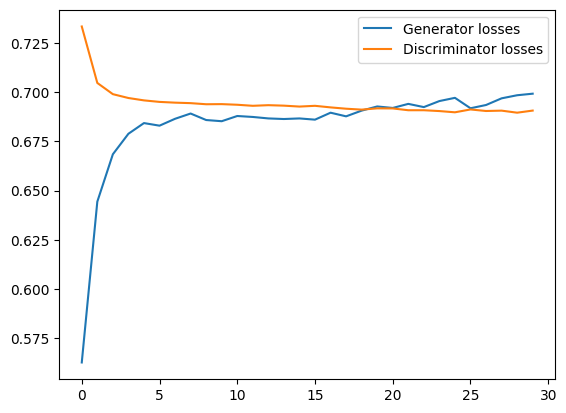

In [41]:
plt.plot(history["generator_loss"], label="Generator losses")
plt.plot(history["discriminator_loss"], label="Discriminator losses")
plt.legend()

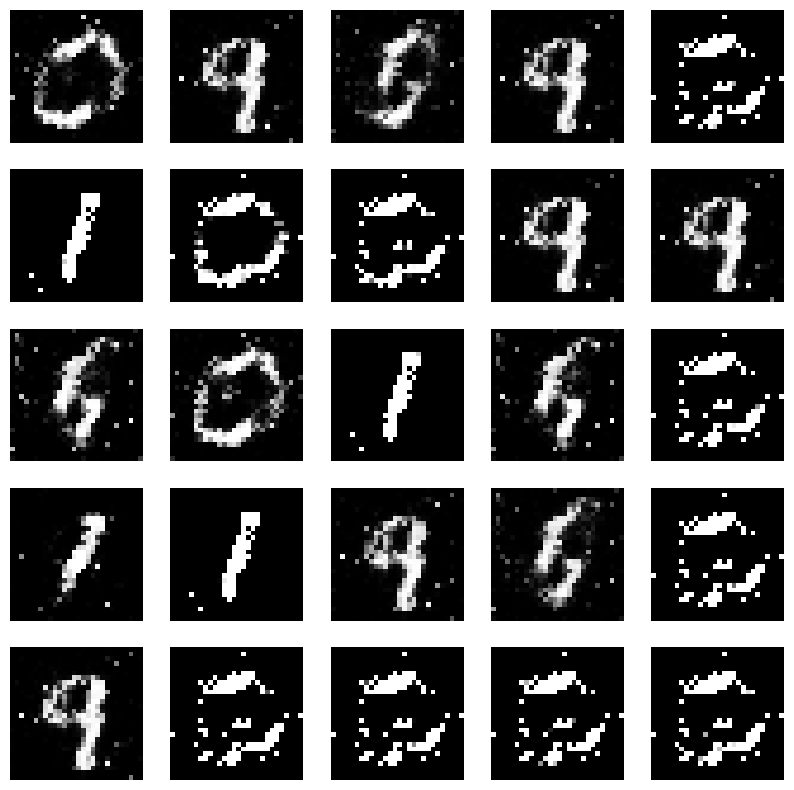

In [46]:
z = torch.randn(25, 128)
gen_imgs = generator(z)
gen_imgs = gen_imgs.squeeze().detach().cpu().numpy()
generator.eval()

with torch.no_grad():
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i], cmap="gray")
        plt.axis("off")
    plt.show()

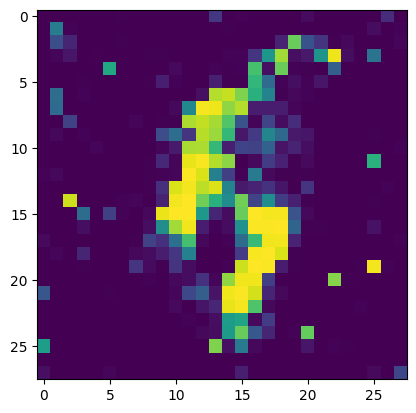

In [60]:
z = torch.randn(1, 128)
generator.eval()

with torch.no_grad():
    img = generator(z)
    

img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
plt.imshow(img)
